# ***Truth or Lie? Training a Mindful BiLSTM***
## Overview of Model Development Steps

- Preprocessed and cleaned political text data.  
- Tokenized, lemmatized, and converted text into numerical sequences.  
- Labeled data as True or False for training.  
- Built and trained a bidirectional LSTM with attention mechanism.  
- Evaluated model performance and loaded the best checkpoint for predictions.

---



In [ ]:
# 1. Libraries & Preprocessing
import pandas as pd
import numpy as np
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Hyperparameters
MAX_LEN = 100
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
DROPOUT_RATE = 0.5
EPOCHS = 10
PATIENCE = 3
MAX_VOCAB = 10000
EMBED_DIM = 100
HIDDEN_DIM = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Text Cleaning and Tokenization
def clean_text(text):
    text = re.sub(r'(Senator|Rep|President)\s\w+', '[POLITICIAN]', str(text))
    text = re.sub(r'\d+/\d+/\d+', '[DATE]', text)
    text = re.sub(r'\$\d+', '[MONEY]', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]




In [ ]:
# 3. Load and Prepare Dataset
df = pd.read_csv('politifact (1).csv')
df = df[~df['veracity'].isin(['Full Flop', 'Half Flip', 'No Flip', 'Half-True'])]

label_map = {
    'True': 'True', 'Mostly True': 'True',
    'False': 'False', 'Mostly False': 'False', 'Pants on Fire!': 'False'
}
df['label'] = df['veracity'].map(label_map)
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

df['tokens'] = df['statement'].apply(clean_text)



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count class distribution
label_counts = df['veracity'].value_counts().sort_index()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title("Class Distribution (Pie Chart)")
plt.axis('equal')
plt.show()


label_counts = df['veracity'].value_counts().sort_index()

print("\nSample Statements from Each Class:")
for label in label_counts.index:
    print(f"\nClass {label} Samples:")
    print(df[df['veracity'] == label]['statement'].sample(3, random_state=42).values)



In [ ]:
# Build vocab
counter = Counter([word for tokens in df['tokens'] for word in tokens])
vocab = ['<PAD>', '<UNK>'] + [word for word, _ in counter.most_common(MAX_VOCAB - 2)]
word2idx = {word: idx for idx, word in enumerate(vocab)}

def encode_tokens(tokens):
    return [word2idx.get(word, word2idx['<UNK>']) for word in tokens[:MAX_LEN]] + \
           [word2idx['<PAD>']] * max(0, MAX_LEN - len(tokens[:MAX_LEN]))

df['input_ids'] = df['tokens'].apply(encode_tokens)

X_train, X_val, y_train, y_val = train_test_split(df['input_ids'].tolist(), df['label_encoded'].tolist(), test_size=0.2, stratify=df['label_encoded'])




In [ ]:
class TextDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [ ]:
# 4. BiLSTM with Attention
class AttentionBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout_rate):
        super(AttentionBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        embed = self.embedding(x)
        lstm_out, _ = self.bilstm(embed)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.dropout(context)
        return self.fc(out).squeeze(1)

model = AttentionBiLSTM(len(vocab), EMBED_DIM, HIDDEN_DIM, DROPOUT_RATE).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# 5. Training Loop with Early Stopping
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(labels.cpu().numpy())

    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)

    # Convert predictions to binary
    binary_preds = [1 if p > 0.5 else 0 for p in all_preds]
    val_accuracy = accuracy_score(all_targets, binary_preds)

    print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break


100%|██████████| 280/280 [00:02<00:00, 121.28it/s]


Epoch 1: Train Loss = 189.3089, Val Loss = 0.6431, Val Accuracy = 0.6265


100%|██████████| 280/280 [00:01<00:00, 223.73it/s]


Epoch 2: Train Loss = 176.3387, Val Loss = 0.6372, Val Accuracy = 0.6354


100%|██████████| 280/280 [00:01<00:00, 229.97it/s]


Epoch 3: Train Loss = 160.5235, Val Loss = 0.6547, Val Accuracy = 0.6363


100%|██████████| 280/280 [00:01<00:00, 230.22it/s]


Epoch 4: Train Loss = 139.8054, Val Loss = 0.7126, Val Accuracy = 0.6408


100%|██████████| 280/280 [00:01<00:00, 200.27it/s]


Epoch 5: Train Loss = 107.9135, Val Loss = 0.7998, Val Accuracy = 0.6180
Early stopping triggered.


In [ ]:
# 6. Evaluation & Metrics
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(labels.numpy())

pred_labels = [1 if p >= 0.5 else 0 for p in all_preds]

acc = accuracy_score(all_targets, pred_labels)
prec = precision_score(all_targets, pred_labels)
rec = recall_score(all_targets, pred_labels)
f1 = f1_score(all_targets, pred_labels)
roc_auc = roc_auc_score(all_targets, all_preds)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")




Accuracy: 0.6354
Precision: 0.6096
Recall: 0.4439
F1 Score: 0.5137
ROC AUC: 0.6744


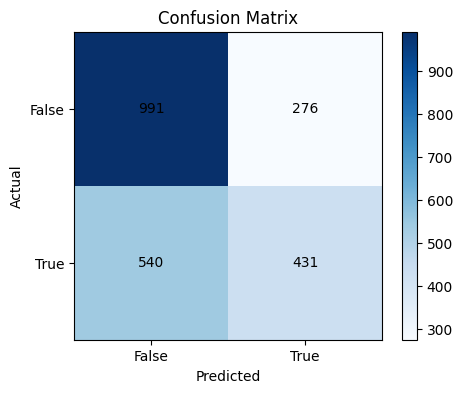

In [ ]:
# 7. Plot Confusion Matrix & ROC
# Confusion Matrix
cm = confusion_matrix(all_targets, pred_labels)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks([0, 1], ['False', 'True'])
plt.yticks([0, 1], ['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.colorbar()
plt.show()




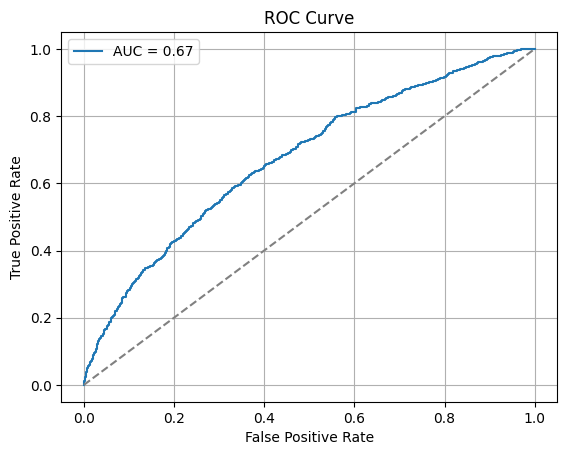

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(all_targets, all_preds)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()